In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K
from keras import optimizers

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.losses import mean_squared_error
from keras import layers as KL

import numpy
import matplotlib.pyplot
import pandas as pd
from pathlib import Path

from keras.layers import Input, Dense, Lambda, Layer, LeakyReLU, ReLU
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, BaseLogger, \
TerminateOnNaN, Callback, ModelCheckpoint, LambdaCallback

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

from keras.constraints import max_norm
# from sklearn.externals.joblib import dump, load

from numpy.random import seed
import time

import json
import pickle
import os
import shutil

import random as rn

np.random.seed(42)
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(12345)

# import ray
# from ray.tune.integration.keras import TuneReporterCallback
# from ray import tune
# from ray.tune.schedulers import AsyncHyperBandScheduler, ASHAScheduler, PopulationBasedTraining
import random
import csv
import importlib
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


from vae_utility import *
from utils import *

In [21]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tqdm import tqdm

In [22]:
cols = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label", 'difficulty']

cat_cols = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']
cont_cols = [x for x in cols if x not in cat_cols]

In [23]:
trainx, valx, ohe = get_train_val(0.2, cols, cat_cols, preprocessing = 'log')

In [24]:
testx, testy, orig_labels= get_test(cols, cat_cols, ohe, preprocessing='log')

In [25]:
batch_size = 400

In [26]:
train_loader = torch.utils.data.DataLoader(trainx, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valx, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(testx, batch_size=400, shuffle=True)

In [27]:
modalities = list(np.unique(orig_labels))

In [28]:
cuda = torch.cuda.is_available()

torch.manual_seed(1)

device = torch.device("cuda" if cuda else "cpu")

# kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
# transform = [transforms.ToTensor()]

In [29]:
original_dim = trainx.shape[1]
intermediate_dim = 20
latent_dim = 4
# batch_size = 200

act_fun = 'relu'
kernel_max_norm = 1000
weight_KL_loss = 0.8

Nf_lognorm = 34
Nf_binomial = original_dim-Nf_lognorm

In [30]:
def RecoProb_forVAE(x, par1, par2, par3):

    N = 0
    nll_loss = 0

    #Log-Normal distributed variables
    mu = par1[:,:Nf_lognorm]
    sigma = par2[:,:Nf_lognorm]
    fraction = par3[:,:Nf_lognorm]
#             fraction = fraction.cpu()
    x_clipped = torch.clamp(x[:,:Nf_lognorm], clip_x_to0, 1e8)
    single_NLL = torch.where(torch.le(x[:,:Nf_lognorm], clip_x_to0),
                            -torch.log(fraction),
                                -torch.log(1-fraction)
                                + torch.log(sigma)
                                + torch.log(x_clipped)
                                + 0.5*torch.mul(torch.div(torch.log(x_clipped) - mu, sigma),
                                                  torch.div(torch.log(x_clipped) - mu, sigma)))
    nll_loss += torch.sum(single_NLL, axis=-1)

    N += Nf_lognorm

    #Binomial distributed variables
    p = 0.5*(1+0.98*torch.tanh(par1[:, N: N+Nf_binomial]))
    single_NLL = -torch.where(torch.eq(x[:, N: N+Nf_binomial],1), torch.log(p), torch.log(1-p))
    nll_loss += torch.sum(single_NLL, axis=-1)
    N += Nf_binomial

    return nll_loss

class InverseSquareRootLinearUnit(nn.Module):

    def __init__(self, min_value = 5e-3):
        super(InverseSquareRootLinearUnit, self).__init__()
        self.min_value =  min_value
        
    def forward(self, x):
        return 1. + self.min_value \
            + torch.where(torch.gt(x, 0), x, torch.div(x, torch.sqrt(1+(x*x)  )))

class ClippedTanh(nn.Module):

    def __init__(self, min_value = 5e-3):
        super(ClippedTanh, self).__init__()

    def forward(self, x):
        return 0.5*(1+0.999*torch.tanh(x))
    
def KL_loss_forVAE(mu, sigma):
    mu_prior = torch.tensor(0)
    sigma_prior = torch.tensor(1)
    kl_loss = torch.mul(torch.mul(sigma, sigma), torch.mul(sigma_prior,sigma_prior))
    div = torch.div(mu_prior - mu, sigma_prior)
    kl_loss += torch.mul(div, div)
    kl_loss += torch.log(torch.div(sigma_prior, sigma)) -1
    return 0.5 * torch.sum(kl_loss, axis=-1)

In [31]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.enc = nn.Sequential(nn.Linear(original_dim, intermediate_dim), nn.ReLU(True)\
                                 , nn.Linear(intermediate_dim, intermediate_dim), nn.ReLU(True))
        
        self.mu = nn.Linear(intermediate_dim, latent_dim)
        self.sigma = nn.Linear(intermediate_dim, latent_dim)
        
        
        self.dec = nn.Sequential(nn.Linear(latent_dim, intermediate_dim), nn.ReLU(True),
                                 nn.Linear(intermediate_dim, intermediate_dim), nn.ReLU(True))
        
        self.par1 = nn.Linear(intermediate_dim, original_dim) 
        self.par2 = nn.Linear(intermediate_dim, Nf_lognorm)
        self.par3 = nn.Linear(intermediate_dim, Nf_lognorm)  
        
        self.act2 = InverseSquareRootLinearUnit()
        self.act3 = ClippedTanh()    
        
    def encode(self, x):
        enc = self.enc(x)
        mu = self.mu(enc)
        sigma_pre = self.sigma(enc)
        return mu, self.act2(sigma_pre)

    def sample(self, mu, sigma):
        std = sigma
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        z = z.view(z.size(0), latent_dim)
        d = self.dec(z)
        par2 = self.par2(d)
        par3 = self.par3(d)
        return self.par1(d), self.act2(par2), self.act3(par3)

    def forward(self, x):
        mu, sigma = self.encode(x.view(x.size(0), original_dim))

#         log_var = self.encodinglayer2_logvar(x)
#         mean = self.encodinglayer2_mean(x)

        z = self.sample(mu, sigma)
        
        return self.decode(z), mu, sigma

In [32]:
def loss_function(x, pars):
    recon_loss = RecoProb_forVAE(x, pars[0], pars[1], pars[2])
    return recon_loss

In [33]:
use_conv = False

In [34]:
if use_conv:
    image_size = 32  # dimension of the image
    hidden_size = 1024  # hidden dimension
    latent_size = 32  # latent vector dimension
    train_data = datasets.SVHN(
        dataset_dir + "SVHN/",
        split="train",
        download=True,
        transform=transforms.Compose([transforms.Resize(64), transforms.ToTensor()]),
    )
    test_data = datasets.SVHN(
        dataset_dir + "SVHN/",
        split="test",
        download=True,
        transform=transforms.Compose([transforms.Resize(64), transforms.ToTensor()]),
    )
else:
#     image_size = 28
    input_size = original_dim  # size of each input
    hidden_size = intermediate_dim  # hidden dimension
    latent_size = latent_dim # latent vector dimension
#     train_data = datasets.FashionMNIST(
#         dataset_dir, train=True, download=True, transform=transforms.ToTensor()
#     )
#     test_data = datasets.FashionMNIST(
#         dataset_dir, train=False, download=True, transform=transforms.ToTensor()
#     )

# trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
# testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=8)

trainloader = torch.utils.data.DataLoader(trainx, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(valx, batch_size=batch_size, shuffle=True)

In [35]:
vae = VAE().to(device)

In [36]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
train_loss = []

In [37]:
epochs = 20

Loss:
111.15518188476562
Loss:
106.27040100097656
Loss:
100.69242095947266
Loss:
94.61680603027344
Loss:
83.63273620605469
Loss:
66.47759246826172
Loss:
46.301177978515625
Loss:
32.848548889160156
Loss:
26.064611434936523
Loss:
20.701751708984375
Loss:
17.87144660949707
Loss:
16.54503059387207
Loss:
14.573089599609375
Loss:
13.466036796569824
Loss:
12.720186233520508
Loss:
12.122154235839844
Loss:
11.573600769042969
Loss:
11.416705131530762
Loss:
11.127728462219238
Loss:
10.122300148010254
Loss:
10.696285247802734
Loss:
11.585235595703125
Loss:
10.361431121826172
Loss:
8.641634941101074
Loss:
9.41296100616455
Loss:
9.07186508178711
Loss:
7.363264560699463
Loss:
7.51736307144165
Loss:
7.9183478355407715
Loss:
7.497530937194824
Loss:
5.950742721557617
Loss:
6.019094467163086
Loss:
5.483016014099121
Loss:
4.167068004608154
Loss:
4.806030750274658
Loss:
4.4510698318481445
Loss:
5.340480327606201
Loss:
3.92313814163208
Loss:
4.5206146240234375
Loss:
3.8182437419891357
Loss:
3.73052883148193

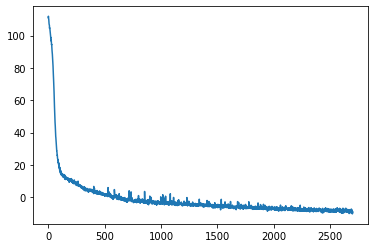

'\nSave the model incase we need to load it again.\n'

In [38]:
"""
Set the model to the training mode first and train
"""
vae.train()
train_loss = []
for epoch in range(epochs):
    for i, images in enumerate(trainloader):
        images = (images.type(torch.FloatTensor)).to(device)
        optimizer.zero_grad()
        pars, mu, sigma = vae(images)
#         if use_conv:

        recon_loss = loss_function(images, pars).mean()
#         CE = F.mse_loss(reconstructed_image, images, reduction="none").sum(-1) #sum columnwinse
#         log_var = torch.log(torch.mul(sigma,sigma))
    
        KLD = KL_loss_forVAE(mu,sigma).mean()
        loss = recon_loss + weight_KL_loss*KLD  # the mean of KL is added to the mean of MSE
        loss.backward()
        train_loss.append(loss.item())
        optimizer.step()

        if i % 10 == 0:
            print("Loss:")
#             print(loss.item()/len(images))
            print(loss.item())

plt.plot(train_loss)
plt.show()

"""
Set the model to the evaluation mode. This is important otherwise you will get inconsistent results. Then load data from the test set.
"""
vae.eval()
vectors = []
with torch.no_grad():
    for i, images in enumerate(testloader):
        images = (images.type(torch.FloatTensor)).to(device)
        reconstructed_image, mean, log_var = vae(images)
#         temp = list(zip(labels.tolist(), mean.tolist()))
#         reconstructed_image = reconstructed_image.view(-1, 1, image_size, image_size)

#         for x in temp:
#             vectors.append(x)
#         if i % 100 == 0:
#             show_images(reconstructed_image.cpu())

#             if use_conv:
#                 img_name = images_dir + "evaluation/DCVAE/" + str(i).zfill(3)
#             else:
#                 img_name = images_dir + "evaluation/VAE/" + str(i).zfill(3)

#             torchvision.utils.save_image(reconstructed_image.cpu(), img_name)

if use_conv:
    """
    Using Singular Value Decomposition, visualise the two largest eigenvalues. Add the labels for each element and create a dataframe.
    """
    labels, z_vectors = list(zip(*vectors))
    z_vectors = torch.tensor(z_vectors)
    U, S, V = torch.svd(torch.t(z_vectors))
    C = torch.mm(z_vectors, U[:, :2]).tolist()
    C = [x + [labels[i]] for i, x in enumerate(C)]

    df = pd.DataFrame(C, columns=["x", "y", "label"])
    df.head()

    sns.lmplot(x="x", y="y", data=df, fit_reg=False, hue="label")

"""
Save the model incase we need to load it again.
"""
# if use_conv:
#     torch.save(vae.state_dict(), model_dir + "DCVAE.pt")
# else:
#     torch.save(vae.state_dict(), model_dir + "VAE.pt")

In [20]:
# testloader = torch.utils.data.DataLoader(valx, batch_size=1, shuffle=True)

In [39]:
testloader = torch.utils.data.DataLoader(testx, batch_size=1)

In [165]:
vae.eval()
losses_t = []
for i, data in enumerate(testloader):
    test_loss = 0
    data = (data.type(torch.FloatTensor)).to(device)
#             data = (data.to(device)).astype(np.float32)
    pars, mu, sigma = vae(data)
    recon_loss = loss_function(data, pars).mean()

    losses_t.append(recon_loss)

In [157]:
sig_losses_t = [losses_t[i] for i in range(len(testy[:len(losses_t)])) if testy[i]==1]
bkg_losses_t = [losses_t[i] for i in range(len(testy[:len(losses_t)])) if testy[i]==0]

In [158]:
bkg_losses_n = [x.cpu().detach().clone().numpy() for x in bkg_losses_t]
sig_losses_n = [x.cpu().detach().clone().numpy() for x in sig_losses_t]

In [159]:
bkg_losses_n = [x.tolist() for x in bkg_losses_n]
sig_losses_n = [x.tolist() for x in sig_losses_n]

In [160]:
histo_start = min(bkg_losses).cpu().detach().clone().numpy().tolist()
histo_end = np.percentile(sig_losses_n, 90)

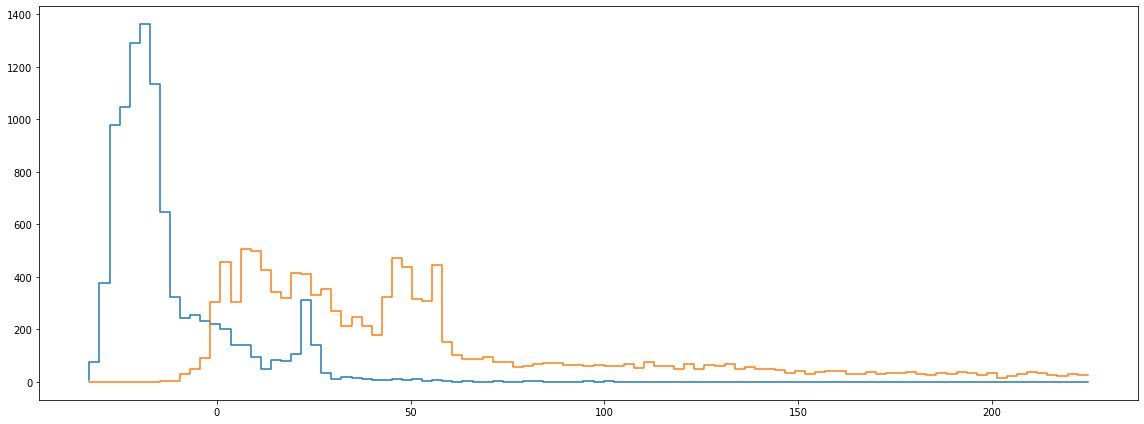

In [166]:
histo_range = (histo_start, histo_end)
f,a = plt.subplots(1,1, figsize=(16, 6))

counts_b = torch.histc(torch.Tensor(bkg_losses_t), bins = bins, min = histo_range[0]
                     , max = histo_range[1])
bin_edges_b = torch.linspace(histo_range[0], histo_range[1], steps=bins)

counts_s = torch.histc(torch.Tensor(sig_losses_t), bins = bins, min = histo_range[0]
                     , max = histo_range[1])
bin_edges_s = torch.linspace(histo_range[0], histo_range[1], steps=bins)


a.step(x=bin_edges_b, y=counts_b, label = 'bkg')
a.step(x=bin_edges_s, y=counts_s, label = 'sig')

plt.tight_layout()

In [167]:
from sklearn.metrics import f1_score, accuracy_score

In [168]:
losses_n = [x.cpu().detach().clone().numpy() for x in losses_t]

In [172]:
ths = np.linspace(histo_start, np.percentile(losses_n, 50), num = 10)

In [175]:
f1_scores = []
for th in ths:
    predicted_label = np.array([1 if x >th else 0 for x in losses_n])
    f1_scores.append(f1_score(testy, predicted_label))

0.9260768335273574


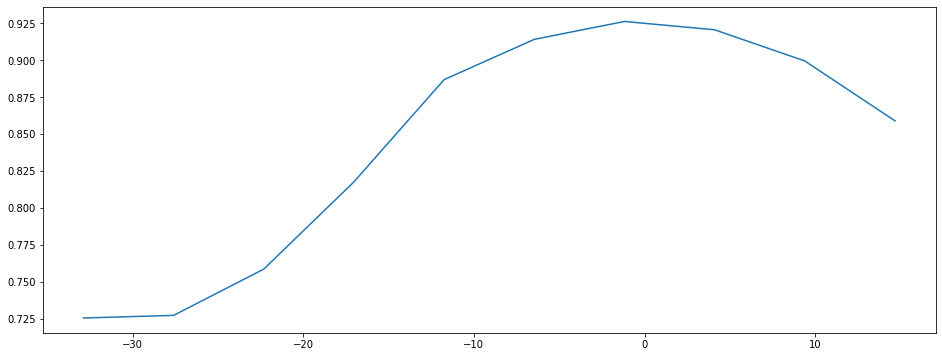

In [176]:
f,a = plt.subplots(1,1, figsize=(16, 6))
a.plot(ths,f1_scores)
print(max(f1_scores))

In [130]:
mapper = {}

In [136]:
mapper['dos'] = ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'mailbomb','processtable',
 'udpstorm','apache2','worm']

mapper['r2l'] = ['ftp_write','guess_passwd', 'imap', 'multihop', 'phf', 'spy', 'warezmaster',
'xlock','xsnoop','snmpguess','snmpgetattack','httptunnel','sendmail','named']

mapper['u2r'] = ['buffer_overflow', 'loadmodule', 'perl', 'rootkit', 'sqlattack', 'xterm', 'ps']

mapper['probe'] = ['ipsweep', 'nmap', 'portsweep', 'satan', 'mscan', 'saint']

# mapper['normal'] = ['normal']

In [335]:
mapper.keys()

dict_keys(['dos', 'r2l', 'u2r', 'probe'])

In [337]:
agg_labels = {}
num_mapper = {}
for mod in modalities:
    for ix, k in enumerate(mapper.keys()):
        if mod in mapper[k]:
            agg_labels[mod] = k + '_' + str(ix+1)
            num_mapper[mod] = ix + 1
#             print(ix+1, k)

In [266]:
agg_labels['normal'] = 'normal_0'
num_mapper['normal'] = 0

In [267]:
orig_labels_mapped = []
for lb in orig_labels:
    orig_labels_mapped.append(num_mapper[lb])
    labels

In [334]:
lb

'mscan'

In [345]:
f1

[[[0.605740733222362, 7460, 1],
  [0.372714940895291, 2885, 2],
  [0.013610970035551041, 67, 3],
  [0.3327149041434756, 2421, 4]],
 [[0.6350557589171704, 7460, 1],
  [0.40225878416062466, 2885, 2],
  [0.015388148828663299, 67, 3],
  [0.360912343470483, 2421, 4]],
 [[0.8084760459570778, 7460, 1],
  [0.6199333405010213, 2885, 2],
  [0.03654213253340605, 67, 3],
  [0.5781492537313432, 2421, 4]],
 [[0.8947178871548619, 7460, 1],
  [0.7200884222160818, 2885, 2],
  [0.064034151547492, 67, 3],
  [0.7348611321900137, 2421, 4]],
 [[0.9284689741191144, 7460, 1],
  [0.6154111360110326, 2885, 2],
  [0.06305578011317704, 67, 3],
  [0.8072531900604434, 2421, 4]],
 [[0.9363114231014678, 7460, 1],
  [0.4085520745131245, 2885, 2],
  [0.04771784232365145, 67, 3],
  [0.7989794058684162, 2421, 4]],
 [[0.9039307128580947, 7460, 1],
  [0.2782362650318321, 2885, 2],
  [0.021377672209026127, 67, 3],
  [0.7398181099248715, 2421, 4]],
 [[0.8693903031143789, 7460, 1],
  [0.19763045122258632, 2885, 2],
  [0.02349

In [343]:
f1_w = []
f1 = []
for th in ths:
    print(th)
    predicted_label = []
    true_label = []
    f1_weighted_scores = []
    for num in np.unique(list(num_mapper.values())): 
#         if mod != 'normal':
            pred_mod = [1 if x > th else 0 for x in losses[1][np.array(orig_labels_mapped) == num]]
            true_label = [1]*len(pred_mod)
            supp = len(pred_mod)
            pred_mod.extend([1 if x > th else 0 for x in losses[1][np.array(orig_labels_mapped) == 0]])      
            true_label.extend([0]*len(losses[1][np.array(orig_labels_mapped) == 0]))           
            f1_weighted_scores.append([f1_score(true_label, pred_mod), supp, num])
#             f1_weighted_scores_dict['f1_{}'.format(num)] = f1_score(true_label, pred_mod)
    lista = [x[0]*x[1] for x in f1_weighted_scores]
    f1_w.append(np.sum(lista)/len(losses[1]))
    f1.append(f1_weighted_scores)
#     f1_weighted_scores.append(f1_weighted_scores_dict)

-42.34905242919922
-31.9675907558865
-21.586129082573784
-11.204667409261067
-0.8232057359483491
9.558255937364365
19.939717610677086
30.321179283989807
40.70264095730252
51.084102630615234


In [297]:
f1_weighted_scores = []
for th in ths:
    print(th)
    predicted_label = []
    true_label = []
    for mod in modalities[20:21]: 
#         if mod != 'normal':
            pred_mod = np.array([int(agg_labels[mod].split('_')[1]) if x > th else int(agg_labels['normal'].split('_')[1])\
                                 for x in losses[1][np.array(orig_labels) == mod]])
            predicted_label.extend(pred_mod)
            true_label.extend([int(agg_labels[mod].split('_')[1])]*len(pred_mod))
    f1_weighted_scores.append(f1_score(true_label, predicted_label, average='weighted'))

-42.34905242919922
-31.9675907558865
-21.586129082573784
-11.204667409261067
-0.8232057359483491
9.558255937364365
19.939717610677086
30.321179283989807
40.70264095730252
51.084102630615234


1.0


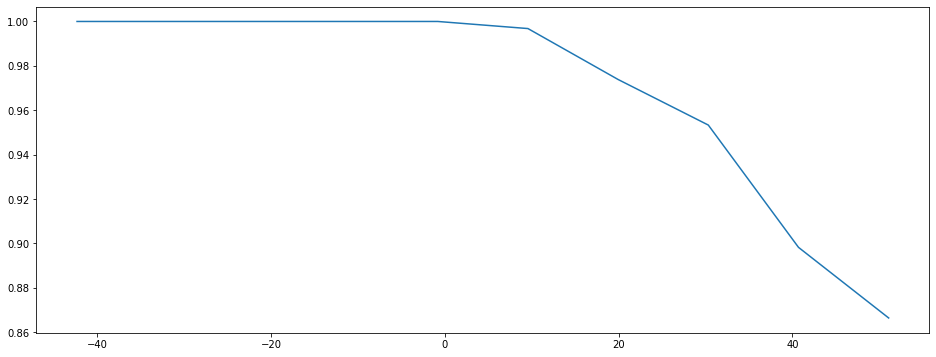

In [298]:
f,a = plt.subplots(1,1, figsize=(16, 6))
a.plot(ths,f1_weighted_scores)
print(max(f1_weighted_scores))

In [57]:
th = ths[np.argmax(f1_weighted_scores)]

In [58]:
predicted_label = []
true_label = []

for ix, mod in enumerate(modalities):
    pred_mod = np.array([ix if x > th else 0 for x in losses[1][orig_labels == mod]])
    predicted_label.extend(pred_mod)
    true_label.extend([ix]*len(pred_mod))

In [59]:
f1 = f1_score(true_label, predicted_label,average='weighted' )
print(f1)

1.0
